# Workflow for processing pointclouds into a map demo'd with L1 data 

This will provide a rough idea of the workflow in a recent report, though much is open to experimentation/improvement so I leave it open to the user. A similar approach was used for the other squares where the point cloud is classified then the results post-processed. Basic understanding of python is required. The aim is to classify the points into classes that can be used for area indicators (e.g. woodland, grassland) and extract the information therein.  

*The information extracted (areas/lengths) may differ slightly from the report as I recropped this from the survey data (accidentally wrote over the report point clouds training field). This also included the loss of the coniferous woodland training labels, so there is now a general woodland class.*

At the outset it must be noted we do not possess a extensive set of ground returns for most of the area (leaf on conditions August), so a Welsh Gov DTM should be obtained (I have provided a subset for this example).The alternative of interpolating large gaps from a classified cloud will result in more spurious heights whereas the WGDTM was acquired leaf off (albeit at a reduced point density). 

*It is also worth noting that the 'ground' in some of the WGDTMs is likely the veg canopy (One of the others in particular). When it comes to estimating height or volume, it may be more sensible to use the cut/fill method on a DSM in those circumstances.*

**There is a lot of repetition of code here that'd ordinarily be reduced to a minimal set of functions. Here it is left for the first two classes so the steps are obvious.**
Also, as this is based on the points, the cover will naturally ovelap(in x,y plane) as it is taken from different levels... 

The point cloud has already had both the flight lines removed, then thinned using the poisson method, as the original L1 pointcloud was far to dense to process.

See preproc.py for this. 

The input point cloud is a ```.ply``` file which should look something like this (below left- try [cloud compare](https://www.danielgm.net/cc/)) to view. Training labels are on the right (training samples are coloured (colours do not corresond to those in later maps). This format is necessary for the machine learning part of the workflow. 

<img img align="left" src="figs/pcloud.png" style="height:300px" />

<img img align="right" src="figs/train.png" style="height:300px" />

In [40]:
%matplotlib inline
from pointutils import learning as l
from pointutils import utils as ut
from pointutils import shape as s
import os
from glob import glob
import numpy as np
from pyntcloud import PyntCloud
import geopandas as gpd
import pandas as pd
import skimage.morphology as skm
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Classify the pointcloud

Using a 'classical' machine learning approach, having already labelled the 
data using cloud compare, cgal polyhedron viewer or one of many labelling 
apps on github. Using Cloud Compare is clumsy (the point segmentation tool),
but the others will require you to be able to compile code/libs 
on your machine (good luck on a CEH laptop....).

The ML is from my lib, in turn derived from scikit learn. xgboost/erf are
equally effective. A k-fold stratified grid search is used, but an evolutionary
approach is also available in the lib 'learning' module.

Please change the `maindir` variable below to where the pointcloud and WGDTM reside or move them to where this notebook is and leave it as is.

In [2]:
maindir = os.getcwd()

The Welsh gov DTM (WGDTM) subset

In [5]:
wgdtm = os.path.join(maindir, 'BetwsWG0.5m.tif')

The pointcloud with training labels

In [6]:
rgbcld = os.path.join(maindir, "Betws_0.5_rgb_final.ply")

Class labels

In [ ]:
clsnms = ['Grass', 'Earth', 'Hedge', 'Tree', 'Shrub', 'Water', 'Road',
          'Building']

This is a relatively slow process at present, due to a lack of parallelism (*cgal is compiled via anaconda with this enabled so not sure why it is not working*). Saving the features to disk would result big disk footprints for each file (many GBs), hence processing on the fly. 

Training is saved as a gunzip file.

In [ ]:
#training file
outtrain = os.path.join(maindir, 'betwstrn.gz')

train, fnames = l.get_training_ply(rgbcld, label_field='training', rgb=True, outFile=outtrain)

Paramaters for the extra trees classifier grid search. Not exhaustive of course.

In [ ]:
param_grid = {"n_estimators": [100],"max_features": ['sqrt', 'log2'],
                         "min_samples_split": [2,3,5],
                         "min_samples_leaf": [5,10,20],
                         "max_depth": [10, 15, 20]}

The models is also saved as a gunzip. No of cores/threads used ```nt = -1``` denotes all available.

In [ ]:
modelerf = outtrain[:-3]+'_erf.gz'
nt = -1

A set of geometric and colour-based features are generated at multiple
scales to train the model. These are generated on the fly as saving directly
to disk creates very large files. The default is to use cgal-based features
(most effective), though pdal or pyntcloud-based are also available. Please 
consult the cgal website c++ api for further details

A k-fold stratified grid search is run with a further held out test set, the accuracy of
which will be plotted. The results are summarised in the returned variable
and the model saved as a .gz file.

In [ ]:
reserf = l.create_model(train, modelerf, clf='erf',params=param_grid, cv=5,
                        cores=nt, class_names=clsnms, ply=True)

Unfortunately the features are calculated on the fly again so another wait....

In [ ]:
outcld = rgbcld[:-4]+'_erf.ply'
l.classify_ply(rgbcld, modelerf, rgb=True, outcld=outcld)

Now to split the classes into seperate clouds

In [ ]:
ut.split_into_classes(outcld)

The seperate classes are in the sepCls dir, from which all the information
and refined(ish) maps may be produced

It is recommened that the point clouds are inspected individually and cleaned
of any misclassification/flaws (cloud compare or cgal polyhedron
very useful here) if the intention is delivery of a product rather than 
experiment for a paper. That is not done here!


In [3]:
clslist = glob(os.path.join(maindir, 'sepCls', '*.ply'))
clslist.sort()

### Trees

Post-process the trees class, including some filtering, gridding and polygonising.

In [50]:
treecld = clslist[3]

The output file for the normalised point cloud.

In [51]:
treeoot = treecld[:-4]+'_tree_cln.ply'

Normalise the pointcloud. Now we can get the height of canopy etc. 

In [ ]:
# Unaccetably SLOW until the quicker version is fixed
ut.nrm_point_dtm(treecld, wgdtm, outcld=treeoot, reader='ply',
                 writer='ply')

Check the points in a viewer - it should now look completely level.

Clean edges (disadvantage of multiscale feature ML approach)

In [52]:
cln = treeoot[:-4]+'_tree_cln_dn.ply'

ut.drop_cld_value(treeoot, column='z', rule='<', val=3, outcld=cln)

A failsafe for if the points go off the edge of the DTM (they will have stupid heights) is to run the code below. This data does not suffer this, but handy in the aforementioned circumastances. 

In [ ]:
ut.drop_cld_value(cln, column='z', rule='>', val=100, outcld=cln)

Tree map output

In [ ]:
treeras = os.path.join(maindir, 'trees.tif')

Now we will grid the trees cloud having cleaned it up. We are gridding the class only here, but you could grid the z values (rather than ```'label'```) to obtain a CHM. 

Please use...
```python
ut.grid_cloud?
```
...in a new cell if you want an explanation of the params.

In [ ]:
ut.grid_cloud(cln, treeras, attribute='label', outtype='max', spref="EPSG:27700", rng_limit="label[3:3]",
              resolution=0.3, dtype='uint8')

Hole filling.

In [ ]:
# dist of 2 may be a bit much....
ut.fill_nodata(treeras, maxSearchDist=2)

Create the final polygon.

In [9]:
treepoly = os.path.join(maindir,'trees.shp')
#ut.polygonize(treeras, treepoly)

Read in the `.shp` file. The no data value (`255`) from the gridded raster is eliminated here.

<AxesSubplot:>

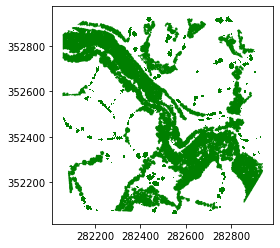

In [10]:
treegdf = gpd.read_file(treepoly)
# Whoops - forgot the no data val in the raster so eliminate here
treegdf.drop(treegdf[treegdf.DN == 255].index, inplace=True)
treegdf.plot(facecolor="green")

Now to calculate the area for the indicator in  question and save the `.shp` now shorn of the nodata value.

In [ ]:
treegdf["Area"] = treegdf['geometry'].area
treegdf.head()
totaltree = treegdf.Area.sum() /10000 # hectares
treegdf.to_file(treepoly)

treegdf.plot(column='Area', legend=True)
plt.title('Total area '+str(totaltree)+' ha')

### Hedges 

Post-process the hedge class, including some filtering, gridding and polygonising.

In [46]:
hedgecld = clslist[2]
hedgeoot = hedgecld[:-4]+'_hedge_cln.ply'

In [ ]:
# SLOW until quicker version is fixed
ut.nrm_point_dtm(hedgecld, wgdtm, outcld=hedgeoot, reader='ply',
                 writer='ply')

In [ ]:
hedgecln = hedgecld[:-4]+'_hedge_cln_dn.ply'
ut.drop_cld_value(hedgeoot, column='z', rule='<', val=0.5, outcld=hedgecln)
ut.drop_cld_value(hedgecln, column='z', rule='>', val=10, outcld=hedgecln)

Outliers - there is a trade off bewtween clean results & ommissions...

In [48]:
dist = 0.1 #10cm
hedgefin = hedgecld[:-4]+'hedge_ol_'+str(dist)+'.ply'
ut.cgal_outlier(hedgecln, hedgefin, distance=dist)

In [ ]:
res = 0.3
hedgeras = os.path.join(maindir, 'hedge'+str(res)+'.tif')

In [ ]:
ut.grid_cloud(hedgefin, hedgeras, attribute='label', outtype='max', 
              spref="EPSG:27700", 
              resolution=res, dtype='uint8')

In [ ]:
ut.fill_nodata(hedgeras, maxSearchDist=1)

For the hedges a little more image processing is required - this is not ideal/transferrable post proc, but to produce reasonable results without manual intervention is required. This is based on assumption that a hedge is elongate, hence some other low lying veg is still present and needs removed (though not discarded). The second reason is we require the medial axis of the hedge polygons to estimate their length, which would not be possible with compact objects.

Likely more training is required on many datasets to reduce this sort of thing, but the following will do the job. 

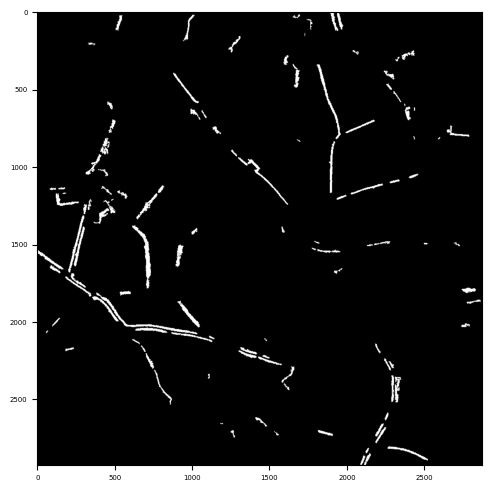

In [146]:
img = ut.raster2array(hedgeras)
img[img==255]=0
plt.figure(figsize = (6,6))
plt.imshow(img, cmap='gray')

Image morph should do the trick - some small holes need to be closed (trust me look in a GIS). 

In [ ]:
# slow.....
img = skm.area_closing(img, area_threshold=4)

Below we use the segment eccentricty to eliminate bushes/shrubs (I use these terms loosely as I assume a hedge to be a long thin thing!).

We can experiment using the Napari viewer though I have provided the 'right' values in the cell after...

A Napari GUI will appear - use the slider to alter the treshold value....

In [ ]:
# connected components
label, _ = nd.label(img)
# the attribute in question
cllabel = ut.colorscale(label, prop='Eccentricity')
cllabel = np.uint8(cllabel*100) # vals for GUI

# napari is a bit slow 
ut.image_thresh(np.uint8(cllabel))

**The chosen values** - hedges in yellow, bushes in greeny/blue

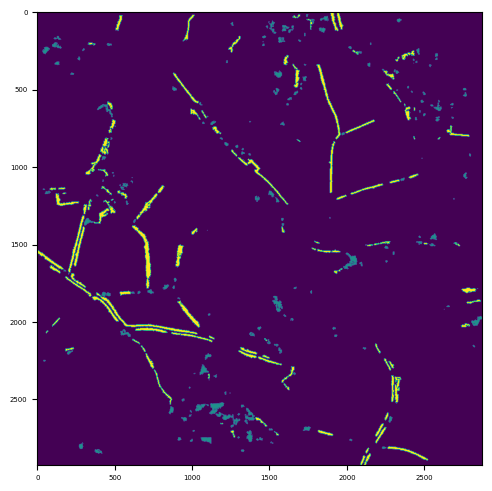

In [137]:
hdge = cllabel > 90
bush = (cllabel <= 90) & (cllabel > 0)

#plot awful code
test = np.zeros_like(hdge, dtype='uint8')
test[np.where(bush==1)]=1
test[np.where(hdge==1)]=2
plt.figure(figsize = (6,6))
plt.imshow(test)

In [ ]:
ut.array2raster(hdge, 1, hedgeras, hedgeras, 3)

So we have the 'non linear' veg left over, this could be merged with the
shrub class later - into a misc. category

In [12]:
bushras = os.path.join(maindir, 'bush'+str(res)+'.tif')
ut.array2raster(bush, 1, hedgeras, bushras, 3)
bushpoly = os.path.join(maindir, 'bush.shp')
ut.polygonize(bushras, bushpoly)

bushgdf = gpd.read_file(bushpoly)
bushgdf["Area"] = bushgdf['geometry'].area
totalbush = bushgdf.Area.sum() /10000 #ha
print('Bush/Shrub area is', totalbush, 'ha')
bushgdf.to_file(bushpoly)

Now calculate the skeleton, which is rather hard to see. Its not perfect, there are some spurious features in there. 

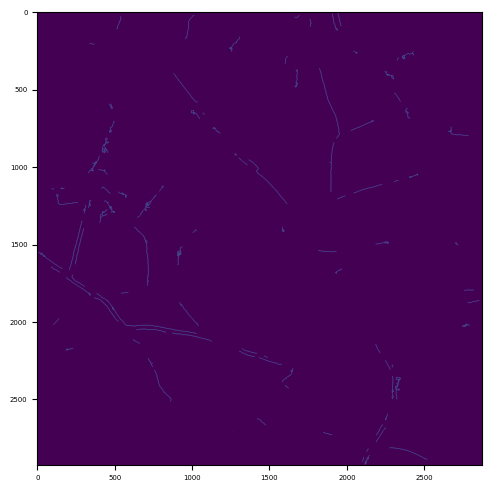

In [138]:
skel = ut.raster_skel(hedgeras, hedgeras[:-4]+'_hdgline.tif', nodata=255,
                      prune_len=70)

plt.figure(figsize = (6,6))
plt.imshow(skel)

Hedgerow length - count the pixels we know the resolution is 0.3m so...

In [ ]:
hedgelength = np.count_nonzero(skel)*0.3/1000 #km
print('Total length is ', hedgelength, 'km')

Hedge mask and area estimate 

In [14]:
hedgepoly = os.path.join(maindir, 'hedge.shp')
ut.polygonize(hedgeras, hedgepoly)

In [15]:
hedgegdf = gpd.read_file(hedgepoly)

#Area....
hedgegdf["Area"] = hedgegdf['geometry'].area
totalhedge = hedgegdf.Area.sum() /10000 #ha
print('Hedge area is', totalhedge, 'ha')
hedgegdf.to_file(hedgepoly)

Plot the results so far....

<AxesSubplot:>

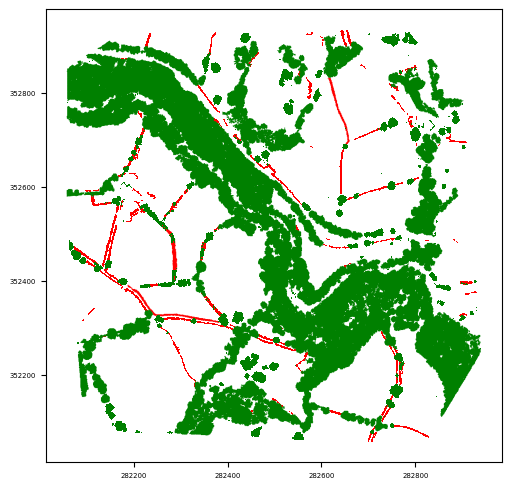

In [142]:
ax = hedgegdf.plot(facecolor='red', figsize=(6,6))
treegdf.plot(ax=ax, facecolor="green")

Calculate the percentage under 2m (was in the indicator list)

In [ ]:
totalhedge = hedgegdf.Area.sum()
less2 = hedgegdf[hedgegdf['chmean'] <=2]
area2 = less2.Area.sum()

In [ ]:
perc = area2 / totalhedge *100
print("Percentage of mapped hedge under 2m is", perc)

**To calculate volume via either DTM difference or cut/fill see [here](https://plugins.qgis.org/plugins/volume_calculation_tool/):**

You can of course use the WGDTM from the directory to this end.

**With this square DTM difference is fine not so with others so use the cut fill when appropriate**


### Bare ground

The same procedure as the other examples. This has been reduced to a function to avoid repetition.

In [ ]:
# inputs/outputs
earthcld = clslist[1]
earth = os.path.join(maindir, 'earth.tif')
earthpoly = os.path.join(maindir, 'earth.shp')
# do it
earthgdf, totalearth = ut._lc_posproc(earthcld, earth, earthpoly)

print('Bare earth area is', totalearth, 'ha')

In [ ]:
ax = earthgdf.plot(facecolor="orange", figsize=(6,6))
hedgegdf.plot(ax=ax, facecolor="red")
treegdf.plot(ax=ax, facecolor='green')

### Grass

The same procedure as the other examples, save for updating the class number.

In [6]:
grasscld = clslist[0]

**The class was zero so edit the cloud quickly**

In [ ]:
pcd = PyntCloud.from_file(grasscld)
pcd.points.label = pcd.points.label+1
pcd.to_file(grasscld)

In [ ]:
# inputs/outputs
grass = os.path.join(maindir, 'grass.tif')
grasspoly = os.path.join(maindir, 'grass.shp')
# do it
grassgdf, totalgrass = ut._lc_posproc(grasscld, grass, grasspoly)

print('Grass area is', totalgrass, 'ha')

Some other low lying unidentified veg was classified as 'shrub', so we can add this to the final map, for the save of completeness.

In [ ]:
# inputs/outputs
shrubcld = clslist[4]
shrub = os.path.join(maindir, 'shrub.tif')
shrubpoly = os.path.join(maindir, 'shrub.shp')
# do it
shrubgdf, totalshrub = ut._lc_posproc(shrubcld, shrub, shrubpoly)

#print('Shrub area is', totalshrub, 'ha')

Plot admin. This may mess up the earlier class numbers but oh well. 

In [31]:
dflist = [earthgdf, grassgdf, shrubgdf, hedgegdf, bushgdf, treegdf]

names = ['Earth', 'Grass', 'Shrub', 'Hedge', 'Bush', 'Tree']

for d,n in zip(dflist, names):
    d['Class']=n
    
biggdf = gpd.GeoDataFrame(pd.concat(dflist, ignore_index=True), crs=dflist[0].crs)

del dflist

The map of cover types mentioned in the report, along with the uncategorised veg (bush) from earlier.

<AxesSubplot:>

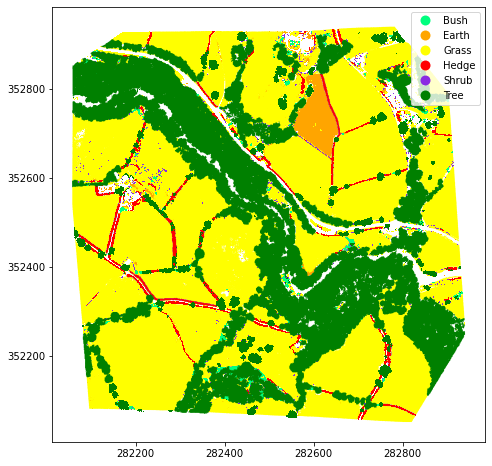

In [43]:
cmap = ListedColormap(["springgreen", "orange", "yellow", "red", "blueviolet", "green"])

biggdf.plot(column='Class', figsize=(8,8), legend=True, cmap=cmap, axis)

## Other tasks

Other things that may be of interest

We may wish to make a CHM from out earlier cleaned up vegetation points. Recall these are already normalised. Note of course we are gridding the `'z'` attribute and specifying `'float32'` datatype this time.

In [57]:
# vars generated earlier on
inlist = [hedgefin, cln]
# the output cloud
vegcld = os.path.join(maindir, 'Vegcld.ply')
# merge
ut.merge_cloud(inlist, vegcld, reader="readers.ply", writer="ply")

grid it 

In [58]:
chm = os.path.join(maindir, 'CHM.tif')

ut.grid_cloud(vegcld, chm, attribute='z', outtype='max', spref="EPSG:27700",
              resolution=0.3, dtype='float32')

Read in and plot it

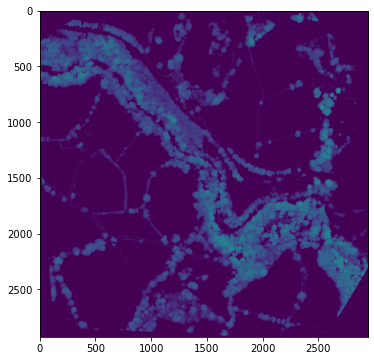

In [85]:
chmimg = ut.raster2array(chm)
chmimg[chmimg==-9999]=0
plt.figure(figsize = (6,6))
plt.imshow(chmimg)

One of the properties of interest was hedge width. The width of an irregular polygon can be approximated by the formula:

`Area / Perimeter * 4`

In [96]:
hedgegdf['Length'] = hedgegdf['geometry'].length

hedgegdf['AvWid'] = hedgegdf['Area'].divide(hedgegdf['Length']) * 4

hedgegdf.to_file(hedgepoly) # update the file                                          

<AxesSubplot:>

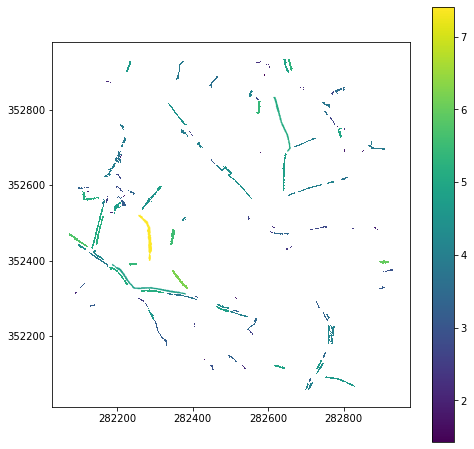

In [101]:
hedgegdf.plot(column='AvWid', figsize=(8,8), legend=True)